In [ ]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [ ]:
# Read data
#data = fetch_california_housing()
#X, y = data.data, data.target
df = pd.read_csv('sample_data/loading_norm_data.csv')

X, y = df.drop("filling_space_percent", axis=1), df['filling_space_percent']/100
y

0      0.817233
1      0.515625
2      0.642438
3      0.672980
4      0.582632
         ...   
622    0.767428
623    0.831830
624    0.000025
625    0.000050
626    0.000248
Name: filling_space_percent, Length: 627, dtype: float64

In [ ]:
# train-test split for model evaluation
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
'''X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)'''

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
 


In [ ]:
# Define the model
model = nn.Sequential(
    nn.Linear(7, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)
 


In [ ]:
n_epochs = 1000   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | R^2_NNRegressor: {r2_score(y_test.detach().numpy(), y_pred.detach().numpy()):.4f}')


Epoch: 0 | R^2_NNRegressor: -0.0423
Epoch: 10 | R^2_NNRegressor: 0.4835
Epoch: 20 | R^2_NNRegressor: 0.5883
Epoch: 30 | R^2_NNRegressor: 0.5808
Epoch: 40 | R^2_NNRegressor: 0.6237
Epoch: 50 | R^2_NNRegressor: 0.6284
Epoch: 60 | R^2_NNRegressor: 0.5161
Epoch: 70 | R^2_NNRegressor: 0.5758
Epoch: 80 | R^2_NNRegressor: 0.5920
Epoch: 90 | R^2_NNRegressor: 0.6227
Epoch: 100 | R^2_NNRegressor: 0.6743
Epoch: 110 | R^2_NNRegressor: 0.6423
Epoch: 120 | R^2_NNRegressor: 0.6166
Epoch: 130 | R^2_NNRegressor: 0.5805
Epoch: 140 | R^2_NNRegressor: 0.5612
Epoch: 150 | R^2_NNRegressor: 0.6078
Epoch: 160 | R^2_NNRegressor: 0.6549
Epoch: 170 | R^2_NNRegressor: 0.6985
Epoch: 180 | R^2_NNRegressor: 0.7397
Epoch: 190 | R^2_NNRegressor: 0.7453
Epoch: 200 | R^2_NNRegressor: 0.7507
Epoch: 210 | R^2_NNRegressor: 0.7494
Epoch: 220 | R^2_NNRegressor: 0.7087
Epoch: 230 | R^2_NNRegressor: 0.7335
Epoch: 240 | R^2_NNRegressor: 0.7392
Epoch: 250 | R^2_NNRegressor: 0.7328
Epoch: 260 | R^2_NNRegressor: 0.7545
Epoch: 270 

MSE: 0.01
RMSE: 0.10


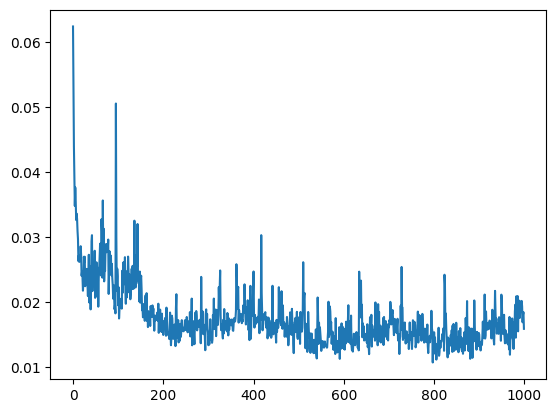

In [ ]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(20):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        #print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
        print(X_sample)
        print(y_pred[0].numpy())
        print(y_test[i].numpy())


tensor([[ 1.1807, -0.8914, -0.9544,  0.4792, -1.4083, -0.2447, -0.8785]])
[0.5927748]
[0.5710016]
tensor([[ 0.1710, -1.0520,  0.0956, -0.3761,  0.0724,  1.5712, -0.4961]])
[0.59294844]
[0.339595]
tensor([[-1.6257, -1.5298, -1.4211, -0.1009, -0.6031, -0.5669, -0.5511]])
[0.38588142]
[0.4487155]
tensor([[-0.3125, -1.3284, -0.4216, -0.3947, -0.5002,  0.4389, -0.7270]])
[0.12433444]
[0.0600489]
tensor([[ 1.1807,  1.1963,  1.2332, -0.3240,  0.6201,  0.7879, -0.7561]])
[0.44314802]
[0.4515764]
tensor([[ 0.3008,  0.3899,  0.2956,  0.3900, -1.3103, -0.6810, -0.8063]])
[0.5434505]
[0.3068663]
tensor([[ 0.2030,  0.2684,  0.0664, -0.2905,  0.0223, -0.6337,  0.5040]])
[0.7435308]
[0.6729798]
tensor([[-0.4677, -1.1810, -1.2253, -0.0488, -0.9191, -0.5659, -0.1451]])
[0.49679434]
[0.7476472]
tensor([[ 1.1807, -1.3090,  1.2332, -0.3500,  0.3690, -0.0700, -0.7001]])
[0.20826238]
[0.194939]
tensor([[-1.2635, -1.4663, -1.0517, -0.3500,  0.5828, -0.1516, -0.6348]])
[0.4391008]
[0.3649818]
tensor([[-0.1166